In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import numpy as np

from torch.utils.tensorboard import SummaryWriter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
train_data = torchvision.datasets.MNIST(
    root= "/data/DataSet/",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)

test_data = torchvision.datasets.MNIST(
    root= "/data/DataSet/",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=(0.5),
            std=(0.5)
        )
    ])
)

In [3]:
# CIFAL10 -> [data][Tuple([3][32][32])(label)]
# MNIST -> [data][Tuple([1][28][28])(label)]
temp = train_data.class_to_idx
labels_map = dict(zip(temp.values(), temp.keys()))

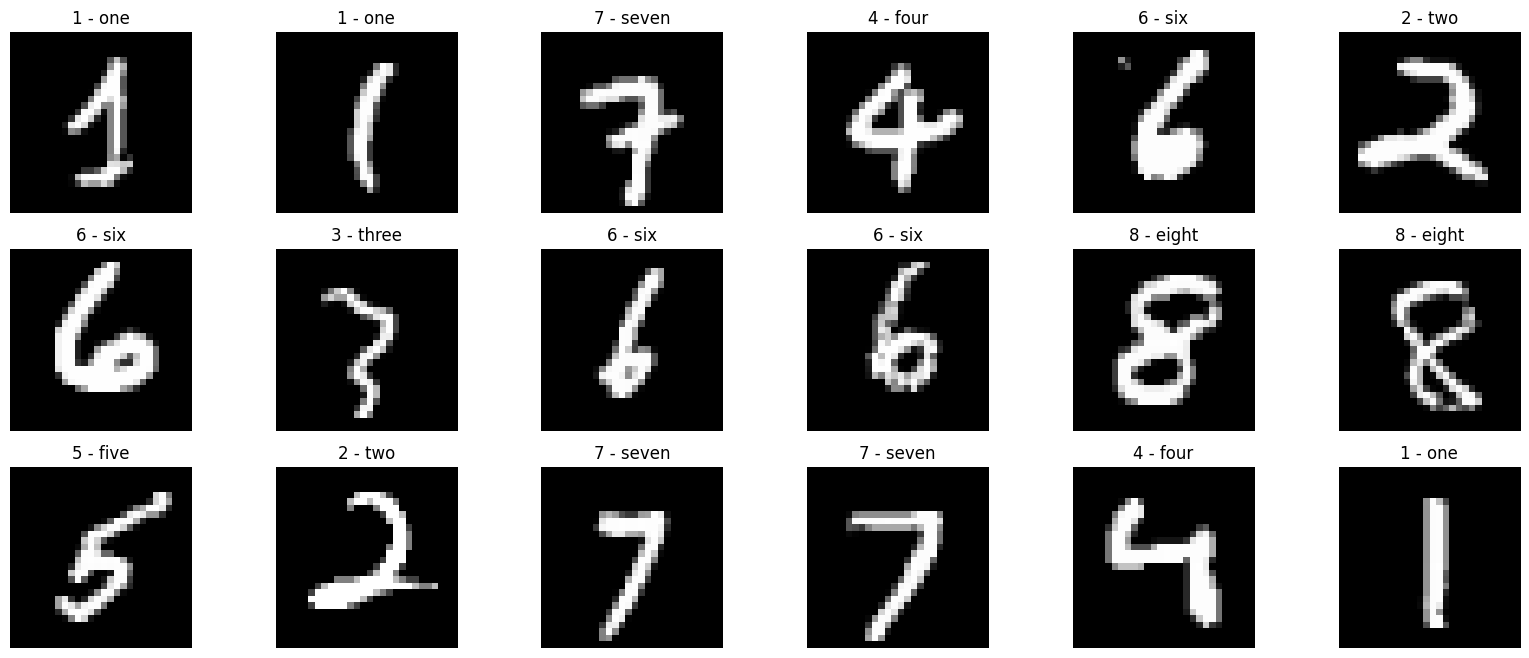

In [4]:
fig = plt.figure(figsize=(20, 8))

col = 6
row = 3

for i in range(1, col * row + 1):
    random_img_number = np.random.randint(len(train_data))
    random_img = train_data[random_img_number][0][0]
    fig.add_subplot(row, col, i)
    plt.title(labels_map[train_data[random_img_number][1]])
    plt.axis('off')
    plt.imshow(random_img, cmap='gray')
plt.show()

In [53]:
class MLP(torch.nn.Module):
    def __init__(self, in_features: int = 784):
        super(MLP, self).__init__()

        def mlp_block(in_features: int, out_features: int, normalize: bool = True, dropout: float = 0.0):

            layers = [
                torch.nn.Linear(
                    in_features=in_features,
                    out_features=out_features
                )
            ]
            if normalize:
                layers.append(
                    torch.nn.BatchNorm1d(
                        num_features=out_features
                    )
                )
            layers.append(
                torch.nn.ReLU()
            )
            
            if dropout:
                layers.append(
                    torch.nn.Dropout(
                        p=dropout
                    )
                )
            
            return layers

        self.model = torch.nn.Sequential(
            *mlp_block(
                # 784 -> 392
                in_features=784,
                out_features=392,
                normalize=False,
                dropout=0.3
            ),
            *mlp_block(
                # 392 -> 196
                in_features=392,
                out_features=196,
                dropout=0.3
            ),
            *mlp_block(
                # 196 -> 98
                in_features=196,
                out_features=98,
                dropout=0.3
            ),
            *mlp_block(
                # 98 -> 49
                in_features=98,
                out_features=49,
                dropout=0.3
            ),
            torch.nn.Linear(
                in_features=49,
                out_features=10
            ),
            torch.nn.Tanh()
        )
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.model(x)

In [54]:
batch_size = 516

train_loader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

for img, label in train_loader:
    print(f"Image: {img.size()}, Type: {img.type()}")
    print(f"Label: {label.size()}, Type: {img.type()}")
    break

Image: torch.Size([516, 1, 28, 28]), Type: torch.FloatTensor
Label: torch.Size([516]), Type: torch.FloatTensor


In [55]:
model = MLP()
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
# criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [66]:
num_epochs = 2

writer = SummaryWriter("Tensorboard/")
for epoch in range(1, num_epochs + 1):
    
    # 훈련 시작
    model.train()
    batch_loss = 0.0

    for count, (imgs, labels) in enumerate(train_loader, start=1):

        # dataloader 통해 가져온 데이터들 gpu로 할당
        x, y = imgs.to(device), labels.to(device)

        # 순전파
        y_hat = model(x)

        # y_hat과 label(y)와 비교
        loss = criterion(y_hat, y)
        
        writer.add_scalar("Loss/train", loss, epoch)

        # 기울기 초기화
        optimizer.zero_grad()

        # 역전파
        loss.backward()

        # 기울기 최적화
        optimizer.step()

writer.close()